# Google Trends Prediction using fbprophet

In [4]:
#Note: before launching Jupyter lab, need to export: export DJANGO_SETTINGS_MODULE=crypto_signal.settings
import django
django.setup()
# Matplotlib for plotting in the notebook
import matplotlib.pyplot as plt
from crypto_track.models import PyTrends

## Import the Prophet Class

In [3]:
from crypto_track.stocker import Prophet

### Prep Data to Instantiate a Prophet object 

For this example, we will be looking at Google trends "Interest Over Time" metric for "Buy Bitcoin" vs. "BTC USD". To retrieve the data, we pull from CryptoTrends object and pass the dataframe to the prophet class. 

In [18]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("db.sqlite3")
df = pd.read_sql_query("select date as ds, btc_usd, buy_bitcoin, trend_ratio from crypto_track_pytrends;", conn)
df.head()

,ds,btc_usd,buy_bitcoin,trend_ratio
0,2018-05-02,9,2,0.22222
1,2018-05-03,10,3,0.30000
2,2018-05-04,9,3,0.33333
3,2018-05-05,10,3,0.30000
4,2018-05-06,8,2,0.25000


In [20]:
df['y'] = df['trend_ratio']
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df.head()

,ds,btc_usd,buy_bitcoin,trend_ratio,y
0,2018-05-02,9,2,0.22222,0.22222
1,2018-05-03,10,3,0.30000,0.30000
2,2018-05-04,9,3,0.33333,0.33333
3,2018-05-05,10,3,0.30000,0.30000
4,2018-05-06,8,2,0.25000,0.25000


In [21]:
df.dtypes

ds             datetime64[ns]
btc_usd                 int64
buy_bitcoin             int64
trend_ratio           float64
y                     float64
dtype: object

In [22]:
future_trend = Prophet(df, 'Trend Ratio')

Prophet Initialized. Data covers 2013-01-01 to 2018-12-02.


Maximum trend_ratio = 17.00 on 2013-06-17.
Minimum trend_ratio = 0.16 on 2018-02-06.
Current trend_ratio = 0.31 on 2018-12-02.



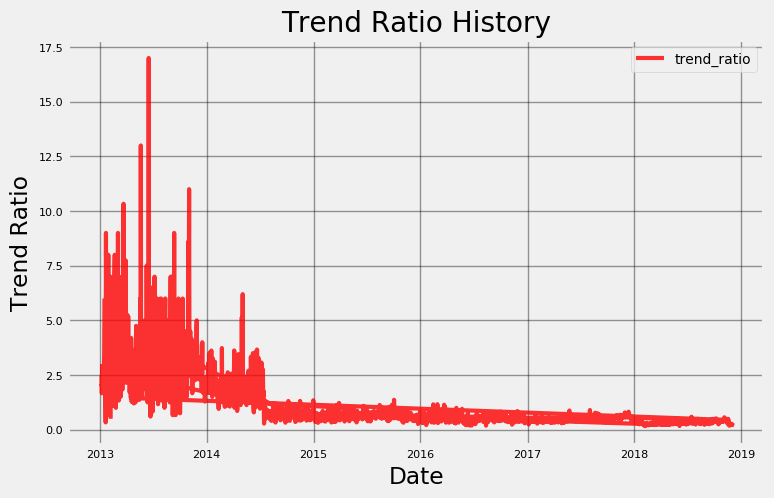

In [24]:
future_trend.training_years=6
future_trend.plot_chart(stats=['trend_ratio'])

Maximum btc_usd = 100.00 on 2017-12-07.
Minimum btc_usd = 0.00 on 2013-01-02.
Current btc_usd = 49.00 on 2018-12-02.

Maximum buy_bitcoin = 100.00 on 2013-11-28.
Minimum buy_bitcoin = 1.00 on 2018-06-04.
Current buy_bitcoin = 15.00 on 2018-12-02.



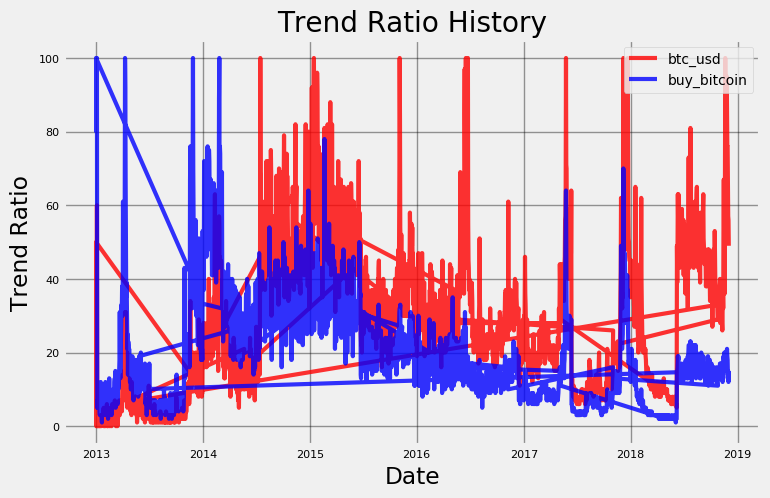

In [25]:
future_trend.plot_chart(stats=['btc_usd','buy_bitcoin'])